In [1]:
#  look for heteroscedastic datasets in statsmodels

In [2]:
import matplotlib.pyplot as plt

In [3]:
# !pip install patsy
from patsy import dmatrices

In [4]:
# ! pip install statsmodels
import statsmodels.api as sm

In [5]:
cancer_dataset = sm.datasets.cancer.load_pandas()

In [6]:
y, X = dmatrices('cancer ~ population', data=cancer_dataset.data, return_type='dataframe')

In [7]:
len(X)

301

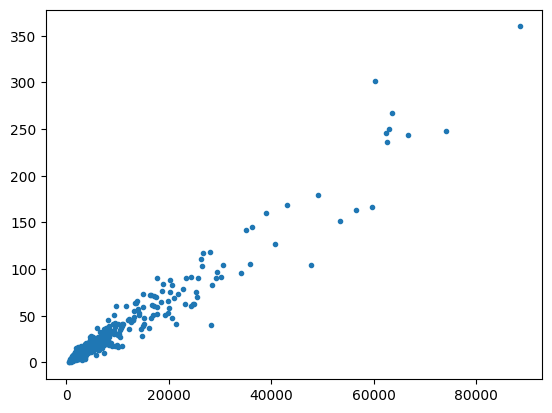

In [8]:
plt.scatter(cancer_dataset.exog, cancer_dataset.endog, marker='.')

In [9]:
# Statistically confirm that the data is heteroscedastic

In [10]:
from statsmodels.stats.diagnostic import het_breuschpagan, het_white

In [11]:
ols = sm.OLS(y, X)

In [12]:
ols_result = ols.fit()

In [13]:
# residuals of a LM are dependent on X

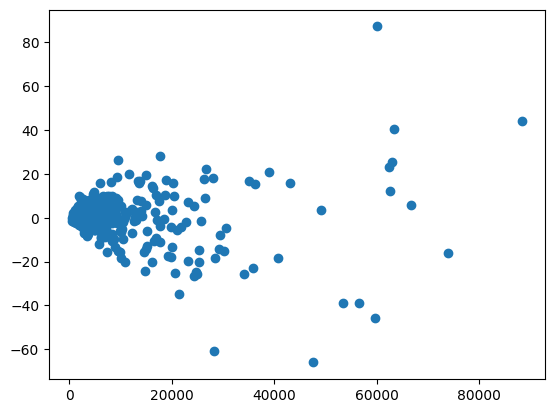

In [14]:
plt.scatter(X.population, ols_result.resid)

In [15]:
# statistical tests confirm this:

In [16]:
het_white(ols_result.resid, X)

(85.53997414283187,
 2.6621383623714153e-19,
 59.154620893488215,
 2.318630760683634e-22)

In [17]:
het_breuschpagan(ols_result.resid, X, robust=False)

(537.3616232659565,
 7.06982038898272e-119,
 117.16552931061003,
 2.9371544178871053e-23)

In [18]:
# Fitting models

In [19]:
# !pip install scikit-learn
import torch
import numpy as np
from sklearn.metrics import r2_score

from heteroscedastic import BetaGaussianMLP, BetaGaussianLM, _radius


In [20]:
torch.set_default_dtype(torch.double)
torch.set_default_tensor_type(torch.DoubleTensor)

/Users/sophiasklaviadis/miniconda3/envs/dsl/lib/python3.10/site-packages/torch/__init__.py:696: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)


In [21]:
X_torch = torch.from_numpy(X.to_numpy())[:, 1].unsqueeze(-1)
y_torch = torch.from_numpy(y.to_numpy()).squeeze()

In [22]:
# leave out 10% of the points at the end: extrapolate

In [23]:
n_test = int(.1 * len(X_torch))
X_test, X_train = X_torch[-n_test:], X_torch[:-n_test]
y_test, y_train = y_torch[-n_test:], y_torch[:-n_test]

In [24]:
# normalize inputs
mu = X_train.mean()
std = torch.norm(X_train - mu)

In [25]:
X_train = (X_train - mu) / std
X_test = (X_test - mu) / std
X_torch = (X_torch - mu) / std

In [26]:
def save_for_plot(model):
    alpha = model.alpha
    model.eval()
    
    t = torch.linspace(X_torch.min(), X_torch.max() + .1, 100).unsqueeze(-1)
    with torch.no_grad():
    
        y_pred, sigma_sq = model(t)
        std_pred = sigma_sq.sqrt()
    
    t = t.squeeze().numpy()
    y_pred = y_pred.squeeze().numpy()
    std_pred = std_pred.squeeze().numpy()

    if alpha == 1:
        # 95% confidence interval.
        a = 2*std_pred
    else:
        # 100% confidence interval.
        R = _radius(1, alpha)
        tau = (-R**2)/2 * (std_pred**2) ** (-(alpha-1) / (alpha+1))
        a = np.sqrt(-2 * tau * std_pred**2)
        
    return t, y_pred, a
    

def plot_model(t, y_pred, a, ax, which="support", fill_color='C0'):
    ax.plot(t, y_pred, color='C0', label="predicted mean")

    ax.fill_between(t,
                    y_pred - a,
                    y_pred + a,
                    alpha=0.2, color=fill_color, label="predicted {}".format(which))
       
    # Plot the truth
    ax.scatter(X_train.squeeze().numpy(), y_train.squeeze().numpy(), marker='.', color='C1', label='train')
    ax.scatter(X_test.squeeze().numpy(), y_test.squeeze().numpy(), marker='x', color='C2', label='test')

    ax.set_ylim(-10, 370)
    ax.set_xlim(None, t[-1])

In [27]:
# baseline

torch.manual_seed(42)
bl_model = BetaGaussianLM(input_size=1, uncertainty=False, heteroscedastic=False, alpha=None)
optimizer = torch.optim.LBFGS(bl_model.parameters(), lr=.01, max_iter=100)

n_epochs = 1000

for epoch in range(n_epochs):
    # Forward pass
    
    def closure():
        optimizer.zero_grad()
        bl_model.train()
        loss = bl_model.loss(X_train, y_train)
        loss.backward()
        return loss

    optimizer.step(closure)

# evaluate R^2
y_pred_train = bl_model.predict(X_train).detach().numpy()
y_pred_test = bl_model.predict(X_test).detach().numpy()
print("R2 train {:.3f} test {:.3f}".format(
    r2_score(y_pred_train, y_train.numpy()),
    r2_score(y_pred_test, y_test.numpy())))
    
print("w", bl_model.pred_y.weight.data, "b", bl_model.pred_y.bias.data)

R2 train 0.829 test 0.562
w tensor([[330.3561]]) b tensor([26.4945])


In [28]:
# try lbfgs

old_loss = np.inf

n_epochs = 1000

results = []

for j, alpha in enumerate([1, 4/3, 1.5, 2]):
    torch.manual_seed(42)
    model = BetaGaussianLM(input_size=1, uncertainty=True, heteroscedastic=False, alpha=alpha)
    
    model.pred_y.weight.data[:] = bl_model.pred_y.weight
    model.pred_y.bias.data[:] = bl_model.pred_y.bias
    optimizer = torch.optim.LBFGS(model.parameters(), lr=.01, line_search_fn='strong_wolfe', max_iter=100)
    
    for epoch in range(n_epochs):
        
        def closure():
            optimizer.zero_grad()
            model.train()
            loss = model.loss(X_train, y_train)
            loss.backward()
            return loss
        
        optimizer.step(closure)
            
    # evaluate R^2
    model.eval()
    y_pred_train = model.predict(X_train).detach().numpy()
    y_pred_test = model.predict(X_test).detach().numpy()
    r2 = "R2 train {:.3f} test {:.3f}".format(
        r2_score(y_pred_train, y_train.numpy()),
        r2_score(y_pred_test, y_test.numpy()))
    
    print(alpha, r2)    
    results.append((alpha, save_for_plot(model), r2))

1 R2 train 0.829 test 0.562
1.3333333333333333 R2 train 0.829 test 0.562
1.5 R2 train 0.829 test 0.562
2 R2 train 0.829 test 0.562


In [29]:
results

[(1,
  (array([-0.06969124, -0.05994682, -0.0502024 , -0.04045799, -0.03071357,
          -0.02096915, -0.01122473, -0.00148031,  0.00826411,  0.01800853,
           0.02775295,  0.03749737,  0.04724178,  0.0569862 ,  0.06673062,
           0.07647504,  0.08621946,  0.09596388,  0.1057083 ,  0.11545272,
           0.12519714,  0.13494155,  0.14468597,  0.15443039,  0.16417481,
           0.17391923,  0.18366365,  0.19340807,  0.20315249,  0.2128969 ,
           0.22264132,  0.23238574,  0.24213016,  0.25187458,  0.261619  ,
           0.27136342,  0.28110784,  0.29085226,  0.30059667,  0.31034109,
           0.32008551,  0.32982993,  0.33957435,  0.34931877,  0.35906319,
           0.36880761,  0.37855202,  0.38829644,  0.39804086,  0.40778528,
           0.4175297 ,  0.42727412,  0.43701854,  0.44676296,  0.45650738,
           0.46625179,  0.47599621,  0.48574063,  0.49548505,  0.50522947,
           0.51497389,  0.52471831,  0.53446273,  0.54420715,  0.55395156,
           0.5636959

Text(0.5, 0, 'Standardized county population')

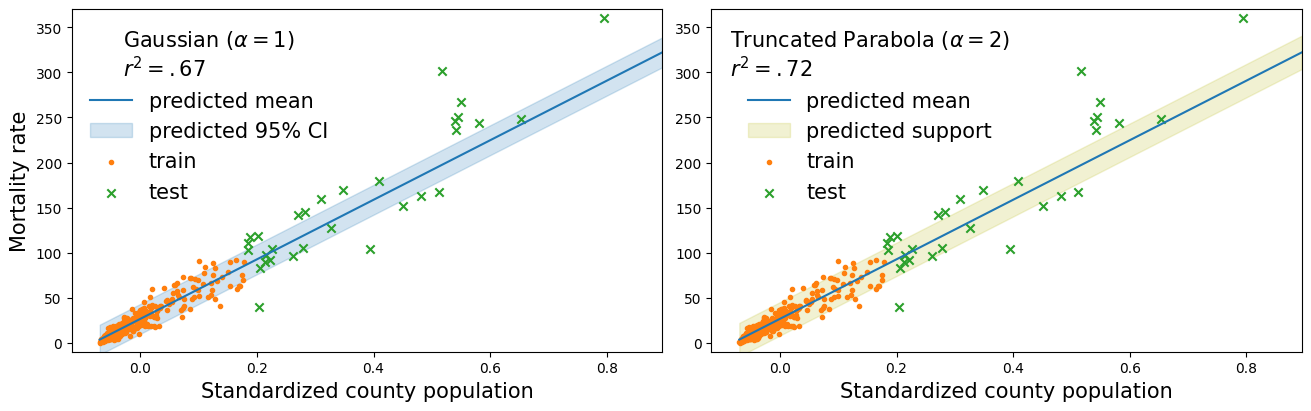

In [30]:
fig, (ax_gauss, ax_tp) = plt.subplots(1, 2, figsize=(13, 4), constrained_layout=True)

plt.rcParams['legend.title_fontsize'] = 15
plt.rcParams['legend.fancybox'] = False
plt.rcParams['legend.frameon'] = False
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

plot_model(*results[0][1], ax_gauss, "95% CI", fill_color='C0')
plot_model(*results[3][1], ax_tp, "support", fill_color='C8')
ax_gauss.legend(title="Gaussian ($\\alpha=1$)\n$r^2=.67$", fontsize=15)
ax_tp.legend(title="Truncated Parabola ($\\alpha=2$)\n$r^2=.72$", fontsize=15)
ax_gauss.set_ylabel("Mortality rate", fontsize=15)
ax_gauss.set_xlabel("Standardized county population", fontsize=15)
ax_tp.set_xlabel("Standardized county population", fontsize=15)
# plt.savefig("heteroscedastic.pdf")